In [1]:
import os
import requests
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch

from transformers import (
    DetrImageProcessor,
    DetrForObjectDetection,
    AutoImageProcessor,
    DeformableDetrForObjectDetection,
)
from PIL import Image, ImageDraw

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Import Object Detection Model

In [10]:
# Initialize the processor and model
# model_name = 'detr-resnet-50'
model_name = "detr-resnet-50-dc5"
# model_name = 'detr-resnet-101'
# model_name = 'detr-resnet-101-dc5'

facebook_detr_model_hf = f"facebook/{model_name}"
processor = DetrImageProcessor.from_pretrained(facebook_detr_model_hf)
model = DetrForObjectDetection.from_pretrained(facebook_detr_model_hf)

# deformable_detr_name_hf = "SenseTime/deformable-detr"
# processor = AutoImageProcessor.from_pretrained(facebook_detr_model_hf)
# model = DeformableDetrForObjectDetection.from_pretrained(deformable_detr_name_hf)

In [11]:
model = model.to(device)
model.eval()
# processor = processor.to(device)

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrTimmConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (act2): ReLU(inplace=True)
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn3): DetrFrozenBatchNorm2d()
              (act3): ReLU(

## Benchmark

#### Prepare batch

In [12]:
image_directory = "./assets"

batch_images = []
target_sizes = []

# Choose a common size for all images
common_size = (800, 1200)

for image_filename in os.listdir(image_directory):
    if image_filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
        image_path = os.path.join(image_directory, image_filename)
        image = Image.open(image_path).convert("RGB")

        # Resize image to the common size
        resized_image = image.resize(common_size)

        # Record the target size
        target_sizes.append(torch.tensor([resized_image.height, resized_image.width]))

        inputs = processor(images=resized_image, return_tensors="pt")
        batch_images.append(inputs["pixel_values"].squeeze().to(device))

# Stack the batched images tensor
batch_images = torch.stack(batch_images)

# Stack the target sizes tensor to get the correct shape
target_sizes = torch.stack(target_sizes).to(device)

#### Make predictions 

In [8]:
# %%timeit -n 100
# with torch.no_grad():
#     # Run the model on the batch
#     outputs = model(pixel_values=batch_images)

In [9]:
# # Process the outputs in batches
# batched_outputs = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)

# # Loop through the results to perform any desired action per image
# for image_index, result in enumerate(batched_outputs):
#     # Do something with the results for each image
#     num_high_conf_detections = len(result['scores'])
#     # print(f"Image {image_index} has {num_high_conf_detections} high-confidence detections.")

#### Display predictions on Directory

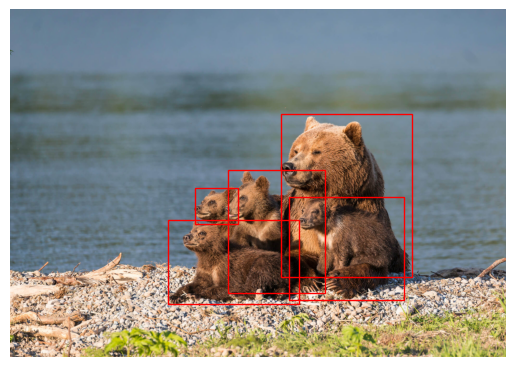

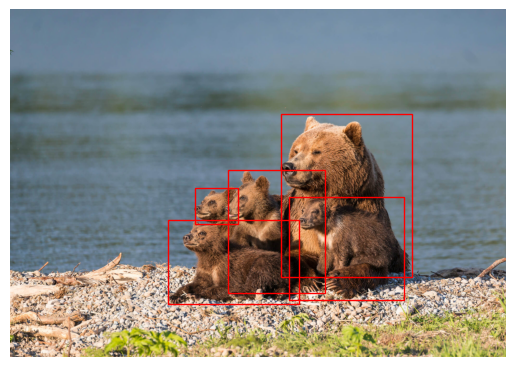

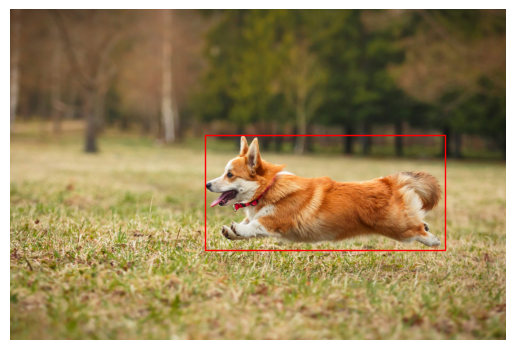

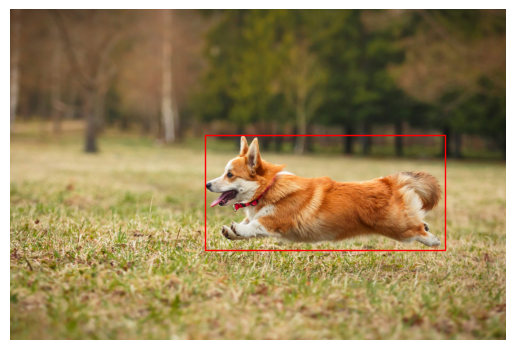

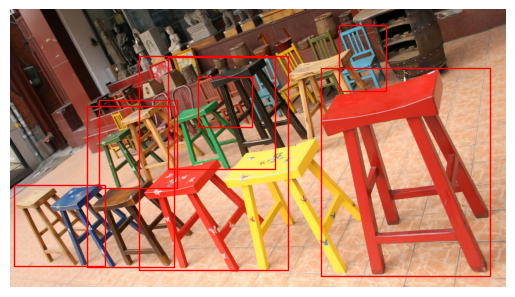

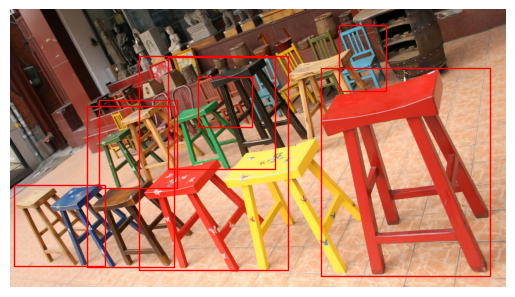

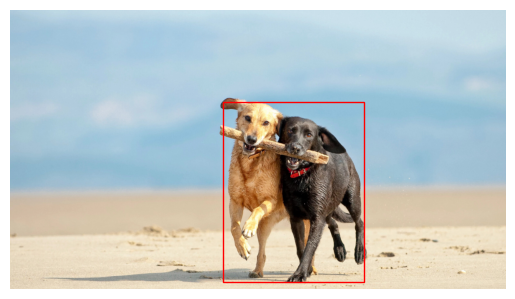

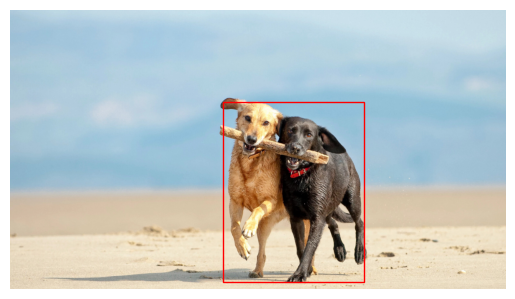

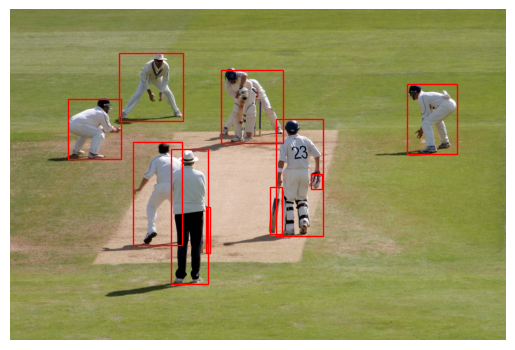

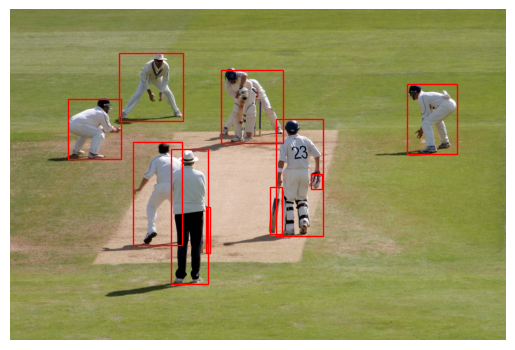

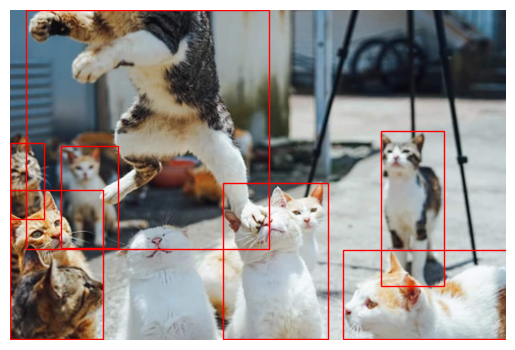

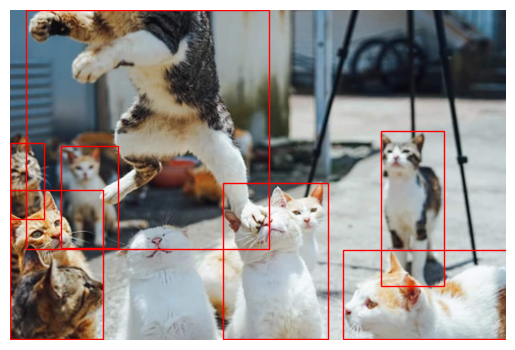

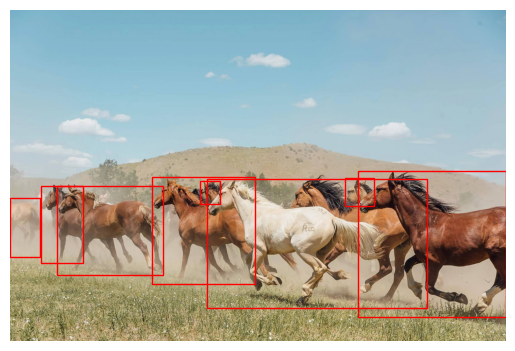

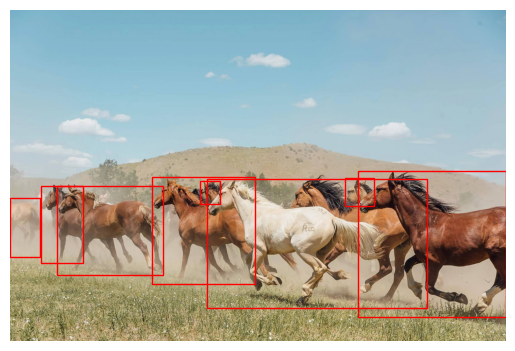

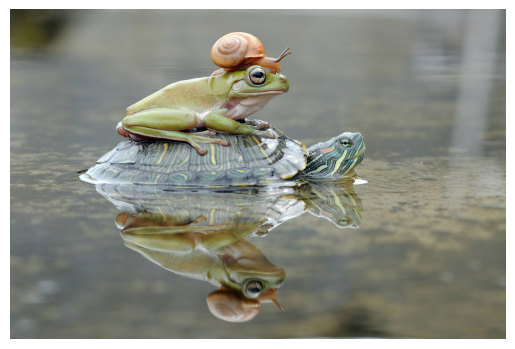

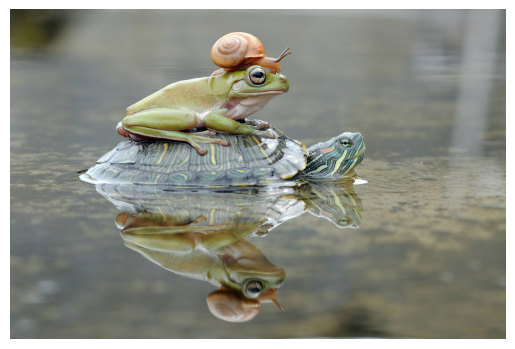

In [55]:
image_directory = "./assets"

# Loop through each image in the directory
for image_filename in os.listdir(image_directory):
    # Make sure to only process image files (e.g., with .jpg, .png extensions)
    if image_filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
        # Construct the full image path
        image_path = os.path.join(image_directory, image_filename)

        # Load the image
        image = Image.open(image_path).convert("RGB")

        # Process the image
        inputs = processor(images=image, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)

        # Convert outputs to COCO API format and filter results
        target_sizes = torch.tensor([image.size[::-1]]).to(device)
        results = processor.post_process_object_detection(
            outputs, target_sizes=target_sizes, threshold=0.92
        )[0]
        # print(results.keys())

        # Move results back to CPU for visualization with matplotlib
        results = {k: v.to("cpu") for k, v in results.items()}

        # Draw rectangles on the image
        fig, ax = plt.subplots(1)
        ax.imshow(image)

        for score, label, box in zip(
            results["scores"], results["labels"], results["boxes"]
        ):
            box = box.tolist()
            x, y, w, h = box[0], box[1], box[2] - box[0], box[3] - box[1]
            rect = patches.Rectangle(
                (x, y), w, h, linewidth=1, edgecolor="r", facecolor="none"
            )
            ax.add_patch(rect)
            # plt.text(x, y, f"{model.config.id2label[label.item()]}: {round(score.item(), 3)}",
            #          bbox=dict(facecolor='yellow', alpha=0.5))

        # Display the image with bounding boxes
        plt.axis("off")
        plt.show()

        # return results['scores'], results['boxes']

## Try OW-DETR Stuff Here

In [16]:
from object_detection_utils import (
    COLORS,
    preprocess,
    box_cxcywh_to_xyxy,
    rescale_bboxes,
    batch_detect,
    detect,
    plot_results,
    plot_batch_detections,
    plot_batch_detections,
    plot_results_avenue,
    load_images_from_folder,
    list_image_files,
    save_cropped_images,
)

In [17]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import requests
import numpy as np

from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [18]:
transform = T.Compose(
    [
        # T.Resize((500, 500)),  # Assuming 800 is the input size for the model
        T.ToTensor(),
        # T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

In [41]:
image_tensor, image = preprocess("./assets/demo6.jpg", transform=transform)

In [42]:
"""Object Dection in Images"""


def detect(image, model, threshold=0.95):
    # Load the image
    # image = Image.open(image_path).convert("RGB")

    # Process the image
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    # Convert outputs to COCO API format and filter results
    target_sizes = torch.tensor([image.size[::-1]]).to(device)
    results = processor.post_process_object_detection(
        outputs, target_sizes=target_sizes, threshold=threshold
    )[0]
    # print(results.keys())

    # Move results back to CPU for visualization with matplotlib
    results = {k: v.to("cpu") for k, v in results.items()}

    # # Draw rectangles on the image
    # fig, ax = plt.subplots(1)
    # ax.imshow(image)

    # for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    #     box = box.tolist()
    #     x, y, w, h = box[0], box[1], box[2] - box[0], box[3] - box[1]
    #     rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    #     ax.add_patch(rect)
    #     # plt.text(x, y, f"{model.config.id2label[label.item()]}: {round(score.item(), 3)}",
    #     #          bbox=dict(facecolor='yellow', alpha=0.5))

    # # Display the image with bounding boxes
    # plt.axis('off')
    # plt.show()

    return results["scores"], results["boxes"]

In [43]:
scores, boxes = detect(image, model)

In [44]:
boxes

tensor([[ 1.3760e+03,  9.9347e+02,  2.0496e+03,  1.3592e+03],
        [-3.1419e-01,  7.4395e+02,  3.8367e+02,  1.3595e+03],
        [ 6.4798e+01,  1.5806e+00,  1.0704e+03,  9.8969e+02],
        [ 2.1018e+02,  5.6134e+02,  4.4629e+02,  9.8423e+02],
        [ 8.8047e+02,  7.1696e+02,  1.3138e+03,  1.3585e+03],
        [ 1.5295e+03,  4.9990e+02,  1.7911e+03,  1.1389e+03]])

## Avenue Prediction using DETR 

In [28]:
train_dir = "./datasets/Avenue Dataset/train__/"
train_video_dirs = [
    "01",
    "02",
    "03",
    "04",
    "05",
    "06",
    "07",
    "08",
    "09",
    "10",
    "11",
    "12",
    "13",
    "14",
    "15",
    "16",
]
train_video_paths = []
total_frames = 0
for dir in train_video_dirs:
    cur_dir = os.path.join(train_dir, dir)
    train_video_paths.append(cur_dir)
    jpg_files = [f for f in os.listdir(cur_dir) if f.endswith(".jpg")]
    total_frames += len(jpg_files)
    print(cur_dir, len(jpg_files))
print(f"Total Frames: {total_frames}")

./datasets/Avenue Dataset/train__/01 1364
./datasets/Avenue Dataset/train__/02 1511
./datasets/Avenue Dataset/train__/03 1487
./datasets/Avenue Dataset/train__/04 1511
./datasets/Avenue Dataset/train__/05 815
./datasets/Avenue Dataset/train__/06 1511
./datasets/Avenue Dataset/train__/07 1099
./datasets/Avenue Dataset/train__/08 1017
./datasets/Avenue Dataset/train__/09 1391
./datasets/Avenue Dataset/train__/10 1223
./datasets/Avenue Dataset/train__/11 781
./datasets/Avenue Dataset/train__/12 145
./datasets/Avenue Dataset/train__/13 366
./datasets/Avenue Dataset/train__/14 510
./datasets/Avenue Dataset/train__/15 353
./datasets/Avenue Dataset/train__/16 244
Total Frames: 15328


In [29]:
test_dir = "./datasets/Avenue Dataset/test__/"
test_video_dirs = [
    "01",
    "02",
    "03",
    "04",
    "05",
    "06",
    "07",
    "08",
    "09",
    "10",
    "11",
    "12",
    "13",
    "14",
    "15",
    "16",
    "17",
    "18",
    "19",
    "20",
    "21",
]
test_video_paths = []
total_frames = 0
for dir in test_video_dirs:
    cur_dir = os.path.join(test_dir, dir)
    test_video_paths.append(cur_dir)
    jpg_files = [f for f in os.listdir(cur_dir) if f.endswith(".jpg")]
    total_frames += len(jpg_files)
    print(cur_dir, len(jpg_files))
print(f"Total Frames: {total_frames}")

./datasets/Avenue Dataset/test__/01 1439
./datasets/Avenue Dataset/test__/02 1211
./datasets/Avenue Dataset/test__/03 923
./datasets/Avenue Dataset/test__/04 947
./datasets/Avenue Dataset/test__/05 1007
./datasets/Avenue Dataset/test__/06 1283
./datasets/Avenue Dataset/test__/07 605
./datasets/Avenue Dataset/test__/08 36
./datasets/Avenue Dataset/test__/09 1175
./datasets/Avenue Dataset/test__/10 841
./datasets/Avenue Dataset/test__/11 472
./datasets/Avenue Dataset/test__/12 1271
./datasets/Avenue Dataset/test__/13 549
./datasets/Avenue Dataset/test__/14 507
./datasets/Avenue Dataset/test__/15 1001
./datasets/Avenue Dataset/test__/16 740
./datasets/Avenue Dataset/test__/17 426
./datasets/Avenue Dataset/test__/18 294
./datasets/Avenue Dataset/test__/19 248
./datasets/Avenue Dataset/test__/20 273
./datasets/Avenue Dataset/test__/21 76
Total Frames: 15324


In [30]:
preds_path = "./datasets/Avenue Dataset/predictions/"
train_preds_path = os.path.join(preds_path, "train/")
test_preds_path = os.path.join(preds_path, "test/")
print(train_preds_path, test_preds_path)

./datasets/Avenue Dataset/predictions/train/ ./datasets/Avenue Dataset/predictions/test/


In [31]:
objects_path = "./datasets/Avenue Dataset/objects/"
train_objects_path = os.path.join(objects_path, "train/")
test_objects_path = os.path.join(objects_path, "test/")
print(train_objects_path, test_objects_path)

./datasets/Avenue Dataset/objects/train/ ./datasets/Avenue Dataset/objects/test/


In [32]:
image_names = [img.split("/")[-1] for img in list_image_files(test_video_paths[-1])]
print(image_names)

['00.jpg', '01.jpg', '02.jpg', '03.jpg', '04.jpg', '05.jpg', '06.jpg', '07.jpg', '08.jpg', '09.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', '24.jpg', '25.jpg', '26.jpg', '27.jpg', '28.jpg', '29.jpg', '30.jpg', '31.jpg', '32.jpg', '33.jpg', '34.jpg', '35.jpg', '36.jpg', '37.jpg', '38.jpg', '39.jpg', '40.jpg', '41.jpg', '42.jpg', '43.jpg', '44.jpg', '45.jpg', '46.jpg', '47.jpg', '48.jpg', '49.jpg', '50.jpg', '51.jpg', '52.jpg', '53.jpg', '54.jpg', '55.jpg', '56.jpg', '57.jpg', '58.jpg', '59.jpg', '60.jpg', '61.jpg', '62.jpg', '63.jpg', '64.jpg', '65.jpg', '66.jpg', '67.jpg', '68.jpg', '69.jpg', '70.jpg', '71.jpg', '72.jpg', '73.jpg', '74.jpg', '75.jpg']


### Train

In [24]:
# %%time
# transform = T.Compose([
#     T.Resize((640, 360)),
#     T.ToTensor(),
#     T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])
# bbox_temp = {}

# for i, video_path in enumerate(train_video_paths):
#     print(video_path)
#     image_names = [img.split('/')[-1] for img in list_image_files(train_video_paths[i])]

#     for image_name in image_names:
#         full_image_path = os.path.join(train_video_paths[i], image_name)

#         image_tensor, image = preprocess(full_image_path, transform=transform)

#         probab, boxes = detect(image, model)

#         # print(boxes)

#         # TODO: Save this dict
#         bbox_temp[image_name] = boxes

#         image_prediction_path = os.path.join(train_preds_path, train_video_dirs[i], image_name)
#         # print(image_prediction_path)

#         # This function can now also create images with bounding boxes and the cropped objects and save them to a location
#         _, cropped_objects = plot_results_avenue(image, probab, boxes, im_size=(640, 360), display_img=False, save_path=image_prediction_path, crop_objects=True)

#         objects_prediction_path = os.path.join(train_objects_path, train_video_dirs[i])

#         save_cropped_images(cropped_objects, objects_prediction_path, image_prefix=image_name.split('.')[0])

./datasets/Avenue Dataset/train__/01


TypeError: detect() missing 1 required positional argument: 'im_size'

### Test

In [40]:
video_names = [video.split("/")[-1] for video in test_video_paths]
print(video_names)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21']


In [56]:
%%time
transform = T.Compose(
    [
        T.Resize((640, 360)),
        T.ToTensor(),
        # T.Normalize(0.5, 0.5)
    ]
)
video_names = [video.split("/")[-1] for video in test_video_paths]
print(video_names)
obj_det_dict = {}

for i, video_path in enumerate(test_video_paths):
    print(video_path)
    image_names = [img.split("/")[-1] for img in list_image_files(test_video_paths[i])]

    bbox_temp = {}

    for frame_idx, image_name in enumerate(image_names):
        full_image_path = os.path.join(test_video_paths[i], image_name)

        image_tensor, image = preprocess(full_image_path, transform=transform)

        probab, boxes = detect(image, model)

        # Process boxes and convert to Python lists with integers
        boxes_list = []
        for box in boxes:
            int_box = [
                int(elem.item()) for elem in box
            ]  # Convert each element to an int and then to a Python list
            boxes_list.append(int_box)

        # TODO: Save this dict
        bbox_temp[frame_idx] = boxes_list

        # image_prediction_path = os.path.join(test_preds_path, test_video_dirs[i], image_name)
        # # print(image_prediction_path)

        # # This function can now also create images with bounding boxes and the cropped objects and save them to a location
        # _, cropped_objects = plot_results_avenue(image, probab, boxes, im_size=(640, 360), display_img=False, save_path=image_prediction_path, crop_objects=True)

        # objects_prediction_path = os.path.join(test_objects_path, test_video_dirs[i])

        # save_cropped_images(cropped_objects, objects_prediction_path, image_prefix=image_name.split('.')[0])

    obj_det_dict[video_names[i]] = bbox_temp

['01_0014', '01_0015', '01_0016', '01_0025', '01_0026', '01_0027', '01_0028', '01_0029', '01_0030', '01_0051', '01_0052', '01_0053', '01_0054', '01_0055', '01_0056', '01_0063', '01_0064', '01_0073', '01_0076', '01_0129', '01_0130', '01_0131', '01_0132', '01_0133', '01_0134', '01_0135', '01_0136', '01_0138', '01_0139', '01_0140', '01_0141', '01_0162', '01_0163', '01_0177', '02_0128', '02_0161', '02_0164', '03_0031', '03_0032', '03_0033', '03_0035', '03_0036', '03_0039', '03_0041', '03_0059', '03_0060', '03_0061', '04_0001', '04_0003', '04_0004', '04_0010', '04_0011', '04_0012', '04_0013', '04_0046', '04_0050', '05_0017', '05_0018', '05_0019', '05_0020', '05_0021', '05_0022', '05_0023', '05_0024', '06_0144', '06_0145', '06_0147', '06_0150', '06_0153', '06_0155', '07_0005', '07_0006', '07_0007', '07_0008', '07_0009', '07_0047', '07_0048', '07_0049', '08_0044', '08_0058', '08_0077', '08_0078', '08_0079', '08_0080', '08_0156', '08_0157', '08_0158', '08_0159', '08_0178', '08_0179', '09_0057'


KeyboardInterrupt



In [34]:
import pickle

# Save the object to a file
with open("obj_dect_avenue_detr_resnet_50_dc5_thresh_95", "wb") as file:
    pickle.dump(obj_det_dict, file)

## ShanghaiTech using DETR 

In [57]:
def create_directories(base_path, dir_names):
    for dir_name in dir_names:
        path = os.path.join(base_path, dir_name)
        os.makedirs(path, exist_ok=True)
        print(f"Directory created: {path}")


def get_jpg_files(directory_path):
    # List all files in the given directory
    all_files = os.listdir(directory_path)

    # Filter and return only jpg/jpeg files
    jpg_files = [file for file in all_files if file.lower().endswith((".jpg", ".jpeg"))]
    return jpg_files

#### Train Directories

In [58]:
train_dir_frames_path = "./datasets/shanghaitech/training/frames/"
train_video_dirs = [file for file in os.listdir(train_dir_frames_path)]
train_video_paths = [
    os.path.join(train_dir_frames_path, file)
    for file in os.listdir(train_dir_frames_path)
]

print(len(train_video_dirs), train_video_dirs[:5])
print(len(train_video_paths), train_video_paths[:5])

330 ['01_001', '01_002', '01_003', '01_004', '01_005']
330 ['./datasets/shanghaitech/training/frames/01_001', './datasets/shanghaitech/training/frames/01_002', './datasets/shanghaitech/training/frames/01_003', './datasets/shanghaitech/training/frames/01_004', './datasets/shanghaitech/training/frames/01_005']


In [59]:
jpg_files = get_jpg_files(train_video_paths[0])
print(jpg_files[:5])

['000.jpg', '001.jpg', '002.jpg', '003.jpg', '004.jpg']


In [60]:
train_video_paths = []
total_frames = 0
for dir in train_video_dirs:
    cur_dir = os.path.join(train_dir_frames_path, dir + "/")
    train_video_paths.append(cur_dir)
    jpg_files = [f for f in os.listdir(cur_dir) if f.endswith(".jpg")]
    total_frames += len(jpg_files)
    print(cur_dir, len(jpg_files))
print(f"Total Frames: {total_frames}")

./datasets/shanghaitech/training/frames/01_001/ 764
./datasets/shanghaitech/training/frames/01_002/ 481
./datasets/shanghaitech/training/frames/01_003/ 768
./datasets/shanghaitech/training/frames/01_004/ 769
./datasets/shanghaitech/training/frames/01_005/ 673
./datasets/shanghaitech/training/frames/01_006/ 505
./datasets/shanghaitech/training/frames/01_007/ 577
./datasets/shanghaitech/training/frames/01_008/ 1009
./datasets/shanghaitech/training/frames/01_009/ 859
./datasets/shanghaitech/training/frames/01_010/ 860
./datasets/shanghaitech/training/frames/01_011/ 737
./datasets/shanghaitech/training/frames/01_012/ 737
./datasets/shanghaitech/training/frames/01_013/ 737
./datasets/shanghaitech/training/frames/01_014/ 737
./datasets/shanghaitech/training/frames/01_015/ 739
./datasets/shanghaitech/training/frames/01_016/ 601
./datasets/shanghaitech/training/frames/01_017/ 840
./datasets/shanghaitech/training/frames/01_018/ 841
./datasets/shanghaitech/training/frames/01_019/ 577
./datasets/

In [61]:
test_dir_frames_path = "./datasets/shanghaitech/testing/frames/"
test_video_dirs = [file for file in os.listdir(test_dir_frames_path)]
test_video_paths = [
    os.path.join(test_dir_frames_path, file)
    for file in os.listdir(test_dir_frames_path)
]

print(len(test_video_dirs), test_video_dirs[:5])
print(len(test_video_paths), test_video_paths[:5])

107 ['01_0014', '01_0015', '01_0016', '01_0025', '01_0026']
107 ['./datasets/shanghaitech/testing/frames/01_0014', './datasets/shanghaitech/testing/frames/01_0015', './datasets/shanghaitech/testing/frames/01_0016', './datasets/shanghaitech/testing/frames/01_0025', './datasets/shanghaitech/testing/frames/01_0026']


#### Predictions Path

In [62]:
preds_path = "./datasets/shanghaitech/predictions/"
train_preds_path = os.path.join(preds_path, "train/")
test_preds_path = os.path.join(preds_path, "test/")
# create_directories(train_preds_path, train_video_dirs)

#### Objects Path

In [63]:
objects_path = "./datasets/shanghaitech/objects/"
train_objects_path = os.path.join(objects_path, "train/")
test_objects_path = os.path.join(objects_path, "test/")
# create_directories(train_objects_path, train_video_dirs)

### Generate Objects and Predictions for Train

- Takes 11h using DETR 101 DC

In [82]:
%%time
im_size = (856, 480)

transform = T.Compose(
    [
        T.Resize(im_size),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)
bbox_temp = {}

for i, video_path in enumerate(train_video_paths):
    print(video_path)
    image_names = [img for img in get_jpg_files(train_video_paths[i])]

    for image_name in image_names:
        full_image_path = os.path.join(train_video_paths[i], image_name)

        image_tensor, image = preprocess(full_image_path, transform=transform)

        probab, boxes = detect(image, model)

        # TODO: Save this dict
        bbox_temp[image_name] = boxes

        image_prediction_path = os.path.join(
            train_preds_path, train_video_dirs[i], image_name
        )
        # print(image_prediction_path)

        # This function can now also create images with bounding boxes and the cropped objects and save them to a location
        _, cropped_objects = plot_results_avenue(
            image,
            probab,
            boxes,
            im_size=im_size,
            display_img=False,
            save_path=image_prediction_path,
            crop_objects=True,
        )

        objects_prediction_path = os.path.join(train_objects_path, train_video_dirs[i])

        save_cropped_images(
            cropped_objects,
            objects_prediction_path,
            image_prefix=image_name.split(".")[0],
        )

./datasets/shanghaitech/frames/01_001
./datasets/shanghaitech/frames/01_002
./datasets/shanghaitech/frames/01_003
./datasets/shanghaitech/frames/01_004
./datasets/shanghaitech/frames/01_005
./datasets/shanghaitech/frames/01_006
./datasets/shanghaitech/frames/01_007
./datasets/shanghaitech/frames/01_008
./datasets/shanghaitech/frames/01_009
./datasets/shanghaitech/frames/01_010
./datasets/shanghaitech/frames/01_011
./datasets/shanghaitech/frames/01_012
./datasets/shanghaitech/frames/01_013
./datasets/shanghaitech/frames/01_014
./datasets/shanghaitech/frames/01_015
./datasets/shanghaitech/frames/01_016
./datasets/shanghaitech/frames/01_017
./datasets/shanghaitech/frames/01_018
./datasets/shanghaitech/frames/01_019
./datasets/shanghaitech/frames/01_020
./datasets/shanghaitech/frames/01_021
./datasets/shanghaitech/frames/01_022
./datasets/shanghaitech/frames/01_023
./datasets/shanghaitech/frames/01_024
./datasets/shanghaitech/frames/01_025
./datasets/shanghaitech/frames/01_026
./datasets/s

### Generate Objects and Predictions for Test

In [64]:
%%time
im_size = (856, 480)
# im_size =

# %matplotlib inline
transform = T.Compose(
    [
        T.Resize(im_size),
        T.ToTensor(),
        # T.Normalize(0.5, 0.5)
    ]
)
bbox_temp = {}
video_names = [video.split("/")[-1] for video in test_video_paths]
print(video_names)
obj_det_dict = {}

for i, video_path in enumerate(test_video_paths):
    print(video_path)
    image_names = [img.split("/")[-1] for img in list_image_files(test_video_paths[i])]

    bbox_temp = {}

    for frame_idx, image_name in enumerate(image_names):
        full_image_path = os.path.join(test_video_paths[i], image_name)

        image_tensor, image = preprocess(full_image_path, transform=transform)

        probab, boxes = detect(image, model, threshold=92)

        # Process boxes and convert to Python lists with integers
        boxes_list = []
        for box in boxes:
            int_box = [
                int(elem.item()) for elem in box
            ]  # Convert each element to an int and then to a Python list
            boxes_list.append(int_box)

        # TODO: Save this dict
        bbox_temp[frame_idx] = boxes_list

        # image_prediction_path = os.path.join(test_preds_path, test_video_dirs[i], image_name)
        # # print(image_prediction_path)

        # # This function can now also create images with bounding boxes and the cropped objects and save them to a location
        # _, cropped_objects = plot_results_avenue(image, probab, boxes, im_size=(640, 360), display_img=False, save_path=image_prediction_path, crop_objects=True)

        # objects_prediction_path = os.path.join(test_objects_path, test_video_dirs[i])

        # save_cropped_images(cropped_objects, objects_prediction_path, image_prefix=image_name.split('.')[0])

    obj_det_dict[video_names[i]] = bbox_temp

['01_0014', '01_0015', '01_0016', '01_0025', '01_0026', '01_0027', '01_0028', '01_0029', '01_0030', '01_0051', '01_0052', '01_0053', '01_0054', '01_0055', '01_0056', '01_0063', '01_0064', '01_0073', '01_0076', '01_0129', '01_0130', '01_0131', '01_0132', '01_0133', '01_0134', '01_0135', '01_0136', '01_0138', '01_0139', '01_0140', '01_0141', '01_0162', '01_0163', '01_0177', '02_0128', '02_0161', '02_0164', '03_0031', '03_0032', '03_0033', '03_0035', '03_0036', '03_0039', '03_0041', '03_0059', '03_0060', '03_0061', '04_0001', '04_0003', '04_0004', '04_0010', '04_0011', '04_0012', '04_0013', '04_0046', '04_0050', '05_0017', '05_0018', '05_0019', '05_0020', '05_0021', '05_0022', '05_0023', '05_0024', '06_0144', '06_0145', '06_0147', '06_0150', '06_0153', '06_0155', '07_0005', '07_0006', '07_0007', '07_0008', '07_0009', '07_0047', '07_0048', '07_0049', '08_0044', '08_0058', '08_0077', '08_0078', '08_0079', '08_0080', '08_0156', '08_0157', '08_0158', '08_0159', '08_0178', '08_0179', '09_0057'

In [65]:
import pickle

# Save the object to a file
with open("obj_dect_shanghaitech_detr_resnet_50_dc5_thresh_92", "wb") as file:
    pickle.dump(obj_det_dict, file)